In [2]:
# Install_Dependencies.ipynb
import os
import sys

# Tampilkan versi Python
print(f"Versi Python: {sys.version}")

# Uninstall versi lama dependensi yang mungkin ada
print("Menghapus versi lama dependensi...")
!pip uninstall -y numpy pandas tensorflow torch transformers scikit-learn

# Install dependensi dengan versi spesifik
print("Menginstal dependensi...")
!pip install numpy==2.0.2 pandas==2.2.2 tensorflow==2.18.0 torch==2.6.0 transformers==4.46.0 scikit-learn==1.6.1

# Install pustaka tambahan untuk back translation
print("Menginstal pustaka untuk back translation...")
!pip install sentencepiece

# Verifikasi versi dependensi
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from transformers import __version__ as transformers_version
from sklearn import __version__ as sklearn_version

print(f"Versi numpy: {np.__version__}")
print(f"Versi pandas: {pd.__version__}")
print(f"Versi tensorflow: {tf.__version__}")
print(f"Versi torch: {torch.__version__}")
print(f"Versi transformers: {transformers_version}")
print(f"Versi scikit-learn: {sklearn_version}")

# Mount Google Drive
from google.colab import drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Cek ketersediaan GPU
print("GPU tersedia:", tf.config.list_physical_devices('GPU'))

# Bersihkan memori
import gc
gc.collect()

Versi Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Menghapus versi lama dependensi...
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: torch 2.5.0
Uninstalling torch-2.5.0:
  Successfully uninstalled torch-2.5.0
Found existing installation: transformers 4.46.0
Uninstalling transformers-4.46.0:
  Successfully uninstalled transformers-4.46.0
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Menginstal dependensi...
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinu

Menginstal pustaka untuk back translation...
Versi numpy: 2.0.2
Versi pandas: 2.2.2
Versi tensorflow: 2.18.0
Versi torch: 2.5.0+cu124
Versi transformers: 4.46.0
Versi scikit-learn: 1.6.1
Mounting Google Drive...
Mounted at /content/drive
GPU tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


120

##SOAL 3a:

##MultiBERT with Back Translation



In [2]:
# MultiBERT.ipynb
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import json
from google.colab import drive, files
import os
from transformers import MarianMTModel, MarianTokenizer
import gc

# Verifikasi versi library
print(f"Versi pandas: {pd.__version__}")
print(f"Versi numpy: {np.__version__}")
print(f"Versi torch: {torch.__version__}")

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Fungsi untuk back translation
def back_translate(texts, source_lang="en", target_lang="fr"):
    model_name = f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}'
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name).to('cuda' if torch.cuda.is_available() else 'cpu')

    # Translate to target language
    translated = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
        translated_ids = model.generate(**inputs)
        translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
        translated.append(translated_text)

    # Translate back to source language
    model_name_back = f'Helsinki-NLP/opus-mt-{target_lang}-{source_lang}'
    tokenizer_back = MarianTokenizer.from_pretrained(model_name_back)
    model_back = MarianMTModel.from_pretrained(model_name_back).to('cuda' if torch.cuda.is_available() else 'cpu')

    back_translated = []
    for text in translated:
        inputs = tokenizer_back(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
        back_translated_ids = model_back.generate(**inputs)
        back_translated_text = tokenizer_back.decode(back_translated_ids[0], skip_special_tokens=True)
        back_translated.append(back_translated_text)

    return back_translated

# Load dataset
dataset_path = '/content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv'
print(f"Loading dataset from {dataset_path}...")
df = pd.read_csv(dataset_path)

# Preprocessing
texts = df['text'].values
labels = df['sentiment'].map({'Positif': 2, 'Netral': 1, 'Negatif': 0}).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Data augmentation with back translation for training data
print("Performing back translation for data augmentation...")
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})
class_counts = train_df['sentiment'].value_counts()
max_count = class_counts.max()

# Augment minority classes
augmented_texts = []
augmented_labels = []
for label in [0, 1]:  # Negatif and Netral
    class_texts = train_df[train_df['sentiment'] == label]['text'].values
    num_to_generate = max_count - len(class_texts)
    if num_to_generate > 0:
        # Select texts to augment
        selected_texts = np.random.choice(class_texts, size=min(num_to_generate, len(class_texts)), replace=True)
        # Perform back translation
        aug_texts = back_translate(selected_texts)
        augmented_texts.extend(aug_texts)
        augmented_labels.extend([label] * len(aug_texts))

# Combine original and augmented data
X_train_aug = np.concatenate([X_train, augmented_texts])
y_train_aug = np.concatenate([y_train, augmented_labels])

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Dataset class
class AmazonDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create data loaders
train_dataset = AmazonDataset(X_train_aug, y_train_aug, tokenizer)
test_dataset = AmazonDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Training
optimizer = AdamW(model.parameters(), lr=2e-5)
model.train()
for epoch in range(3):
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"Epoch {epoch+1}/3, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Metrics
cm = confusion_matrix(true_labels, predictions)
acc = accuracy_score(true_labels, predictions)
prec, rec, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

# Save results
results = {
    'model': 'MultiBERT',
    'confusion_matrix': cm.tolist(),
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1
}
with open('/content/drive/MyDrive/colab/multbert_aug_results.json', 'w') as f:
    json.dump(results, f)
files.download('/content/drive/MyDrive/colab/multbert_aug_results.json')

# Display results
print("\nMultiBERT Results (with augmentation):")
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Clean up
gc.collect()
torch.cuda.empty_cache()

Versi pandas: 2.2.2
Versi numpy: 2.0.2
Versi torch: 2.6.0+cu124
Mounting Google Drive...
Mounted at /content/drive
Loading dataset from /content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv...
Performing back translation for data augmentation...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/301M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 0.8213
Epoch 2/3, Loss: 0.4532
Epoch 3/3, Loss: 0.0552


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


MultiBERT Results (with augmentation):
Confusion Matrix:
[[ 56   0   9]
 [  0  19   0]
 [ 10   0 206]]
Accuracy: 0.9367
Precision: 0.9370
Recall: 0.9367
F1 Score: 0.9368


##SOAL 3b:

##LSTM with FastText and Back Translation


In [4]:
# LSTM_FastText.ipynb
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import json
from google.colab import drive, files
import os
import gc
from transformers import MarianMTModel, MarianTokenizer
import zipfile

# Verifikasi versi library
print(f"Versi pandas: {pd.__version__}")
print(f"Versi numpy: {np.__version__}")
print(f"Versi tensorflow: {tf.__version__}")

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Path file zip dan output unzip
fasttext_zip_path = '/content/drive/MyDrive/colab/wiki-news-300d-1M.vec.zip'
fasttext_file = '/content/wiki-news-300d-1M.vec'

# Unzip file FastText jika belum ada
if not os.path.exists(fasttext_file):
    print(f"File {fasttext_file} tidak ditemukan. Mengekstrak {fasttext_zip_path}...")
    if not os.path.exists(fasttext_zip_path):
        raise FileNotFoundError(f"File zip {fasttext_zip_path} tidak ditemukan di folder colab.")
    with zipfile.ZipFile(fasttext_zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    if not os.path.exists(fasttext_file):
        raise FileNotFoundError(f"Gagal mengekstrak {fasttext_file}. Pastikan file zip berisi wiki-news-300d-1M.vec.")

# Fungsi untuk back translation
def back_translate(texts, source_lang="en", target_lang="fr"):
    model_name = f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}'
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name).to('cuda' if torch.cuda.is_available() else 'cpu')

    translated = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
        translated_ids = model.generate(**inputs)
        translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
        translated.append(translated_text)

    model_name_back = f'Helsinki-NLP/opus-mt-{target_lang}-{source_lang}'
    tokenizer_back = MarianTokenizer.from_pretrained(model_name_back)
    model_back = MarianMTModel.from_pretrained(model_name_back).to('cuda' if torch.cuda.is_available() else 'cpu')

    back_translated = []
    for text in translated:
        inputs = tokenizer_back(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
        back_translated_ids = model_back.generate(**inputs)
        back_translated_text = tokenizer_back.decode(back_translated_ids[0], skip_special_tokens=True)
        back_translated.append(back_translated_text)

    return back_translated

# Load dataset
dataset_path = '/content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv'
print(f"Loading dataset from {dataset_path}...")
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset tidak ditemukan di {dataset_path}. Pastikan file ada di folder yang benar.")
df = pd.read_csv(dataset_path)

# Preprocessing
texts = df['text'].values
labels = df['sentiment'].map({'Positif': 2, 'Netral': 1, 'Negatif': 0}).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Data augmentation with back translation
print("Performing back translation for data augmentation...")
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})
class_counts = train_df['sentiment'].value_counts()
max_count = class_counts.max()

augmented_texts = []
augmented_labels = []
for label in [0, 1]:
    class_texts = train_df[train_df['sentiment'] == label]['text'].values
    num_to_generate = max_count - len(class_texts)
    if num_to_generate > 0:
        selected_texts = np.random.choice(class_texts, size=min(num_to_generate, len(class_texts)), replace=True)
        aug_texts = back_translate(selected_texts)
        augmented_texts.extend(aug_texts)
        augmented_labels.extend([label] * len(aug_texts))

X_train_aug = np.concatenate([X_train, augmented_texts])
y_train_aug = np.concatenate([y_train, augmented_labels])

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_aug)
sequences = tokenizer.texts_to_sequences(X_train_aug)
X_train_aug = pad_sequences(sequences, maxlen=100)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=100)

# Load FastText embeddings
print(f"Loading FastText embeddings dari {fasttext_file}...")
embeddings_index = {}
with open(fasttext_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("FastText embeddings loaded.")

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
del embeddings_index
gc.collect()

# Build LSTM model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_aug, y_train_aug, epochs=5, batch_size=16, validation_split=0.2, verbose=1)

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Save results
results = {
    'model': 'LSTM FastText',
    'confusion_matrix': cm.tolist(),
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1
}
output_path = '/content/drive/MyDrive/colab/lstm_fasttext_aug_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f)
files.download(output_path)

# Display results
print("\nLSTM FastText Results (with augmentation):")
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Clean up
gc.collect()

Versi pandas: 2.2.2
Versi numpy: 2.0.2
Versi tensorflow: 2.18.0
Mounting Google Drive...
Mounted at /content/drive
File /content/wiki-news-300d-1M.vec tidak ditemukan. Mengekstrak /content/drive/MyDrive/colab/wiki-news-300d-1M.vec.zip...
Loading dataset from /content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv...
Performing back translation for data augmentation...


/usr/local/lib/python3.11/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Loading FastText embeddings dari /content/wiki-news-300d-1M.vec...
FastText embeddings loaded.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.6313 - loss: 0.9142 - val_accuracy: 0.2611 - val_loss: 1.1817
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step - accuracy: 0.6807 - loss: 0.7252 - val_accuracy: 0.2866 - val_loss: 1.1314
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 114ms/step - accuracy: 0.7550 - loss: 0.5947 - val_accuracy: 0.4140 - val_loss: 0.8416
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.7562 - loss: 0.5919 - val_accuracy: 0.4013 - val_loss: 0.9559
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7585 - loss: 0.5381 - val_accuracy: 0.3885 - val_loss: 0.8124
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


LSTM FastText Results (with augmentation):
Confusion Matrix:
[[  0   0  65]
 [  0  16   3]
 [  0   1 215]]
Accuracy: 0.7700
Precision: 0.6066
Recall: 0.7700
F1 Score: 0.6767


957

In [1]:
# Install_Dependencies.ipynb
import os
import sys
import gc

print(f"Versi Python: {sys.version}")


# Catatan: Setelah runtime restart, jalankan cell ini lagi mulai dari sini
print("Menghapus versi lama dependensi...")
!pip uninstall -y numpy pandas tensorflow torch transformers scikit-learn sacremoses torchaudio torchvision tensorflow-decision-forests ydf thinc tensorflow-text tf-keras

print("Menginstal dependensi...")
!pip install numpy==1.25.2
!pip install pandas==2.2.2
!pip install tensorflow==2.17.0
!pip install torch==2.4.1
!pip install transformers==4.45.2
!pip install scikit-learn==1.6.1 sentencepiece sacremoses
!pip install protobuf==4.25.5

import numpy as np
import pandas as pd
import tensorflow as tf
import torch
from transformers import __version__ as transformers_version
from sklearn import __version__ as sklearn_version

print(f"Versi numpy: {np.__version__}")
print(f"Versi pandas: {pd.__version__}")
print(f"Versi tensorflow: {tf.__version__}")
print(f"Versi torch: {torch.__version__}")
print(f"Versi transformers: {transformers_version}")
print(f"Versi scikit-learn: {sklearn_version}")

from google.colab import drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("GPU tersedia:", tf.config.list_physical_devices('GPU'))
gc.collect()

Versi Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Menghapus versi lama dependensi...
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: torch 2.6.0
Uninstalling torch-2.6.0:
  Successfully uninstalled torch-2.6.0
Found existing installation: transformers 4.45.2
Uninstalling transformers-4.45.2:
  Successfully uninstalled transformers-4.45.2
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: sacremoses 0.1.1
Uninstalling sacremoses-0.1.1:
  Successfully uninstalled sacremoses-0.1.1
Found existing installation: tensorflow_decision_forests 1.11.0
Uninstalli

  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.47.2 requires scikit-learn, which is not installed.
tsfresh 0.21.0 requires scikit-learn>=0.22.0, which is not installed.
libpysal 4.13.0 requires scikit-learn>=1.1, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.
fastai 2.7.19 requires scikit-learn, which is not installed.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
mlxtend 0.23.4 require

120

##SOAL 3c:

##CNN with GloVe and Back Translation



In [1]:
# CNN_GloVe_Preprocess.ipynb (pemuatan dataset, augmentasi back translation, tokenisasi, dan pembuatan embedding matrix, lalu menyimpan hasilnya ke file.)

import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
from google.colab import drive
import os
import gc
from transformers import MarianMTModel, MarianTokenizer
import zipfile
import torch
from sklearn.model_selection import train_test_split

# Verifikasi versi library
print(f"Versi pandas: {pd.__version__}")
print(f"Versi numpy: {np.__version__}")
print(f"Versi torch: {torch.__version__}")

# Bersihkan memori
torch.cuda.empty_cache()
gc.collect()

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Path file zip dan output unzip
glove_zip_path = '/content/drive/MyDrive/colab/glove.6B.300d.txt.zip'
glove_file = '/content/glove.6B.300d.txt'

# Unzip file GloVe jika belum ada
if not os.path.exists(glove_file):
    print(f"File {glove_file} tidak ditemukan. Mengekstrak {glove_zip_path}...")
    if not os.path.exists(glove_zip_path):
        raise FileNotFoundError(f"File zip {glove_zip_path} tidak ditemukan di folder colab.")
    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    if not os.path.exists(glove_file):
        raise FileNotFoundError(f"Gagal mengekstrak {glove_file}. Pastikan file zip berisi glove.6B.300d.txt.")

# Fungsi untuk back translation dengan retry
def back_translate(texts, source_lang="en", target_lang="fr", max_retries=3):
    for attempt in range(max_retries):
        try:
            model_name = f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}'
            tokenizer = MarianTokenizer.from_pretrained(model_name, cache_dir='/content/hf_cache')
            model = MarianMTModel.from_pretrained(model_name, cache_dir='/content/hf_cache').to('cuda' if torch.cuda.is_available() else 'cpu')

            translated = []
            for text in texts:
                inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
                translated_ids = model.generate(**inputs)
                translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
                translated.append(translated_text)

            model_name_back = f'Helsinki-NLP/opus-mt-{target_lang}-{source_lang}'
            tokenizer_back = MarianTokenizer.from_pretrained(model_name_back, cache_dir='/content/hf_cache')
            model_back = MarianMTModel.from_pretrained(model_name_back, cache_dir='/content/hf_cache').to('cuda' if torch.cuda.is_available() else 'cpu')

            back_translated = []
            for text in translated:
                inputs = tokenizer_back(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
                back_translated_ids = model_back.generate(**inputs)
                back_translated_text = tokenizer_back.decode(back_translated_ids[0], skip_special_tokens=True)
                back_translated.append(back_translated_text)

            return back_translated
        except Exception as e:
            print(f"Percobaan {attempt+1} gagal: {e}")
            if attempt == max_retries - 1:
                print("Gagal melakukan back translation. Menggunakan teks asli.")
                return texts
            continue

# Load dataset
dataset_path = '/content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv'
print(f"Loading dataset from {dataset_path}...")
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset tidak ditemukan di {dataset_path}.")
df = pd.read_csv(dataset_path)

# Preprocessing
texts = df['text'].values
labels = df['sentiment'].map({'Positif': 2, 'Netral': 1, 'Negatif': 0}).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Data augmentation with back translation
print("Performing back translation for data augmentation...")
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})
class_counts = train_df['sentiment'].value_counts()
max_count = class_counts.max()

augmented_texts = []
augmented_labels = []
for label in [0, 1]:
    class_texts = train_df[train_df['sentiment'] == label]['text'].values
    num_to_generate = max_count - len(class_texts)
    if num_to_generate > 0:
        selected_texts = np.random.choice(class_texts, size=min(num_to_generate, len(class_texts)), replace=True)
        aug_texts = back_translate(selected_texts)
        augmented_texts.extend(aug_texts)
        augmented_labels.extend([label] * len(aug_texts))

X_train_aug = np.concatenate([X_train, augmented_texts])
y_train_aug = np.concatenate([y_train, augmented_labels])

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train_aug)
sequences = tokenizer.texts_to_sequences(X_train_aug)
X_train_aug = pad_sequences(sequences, maxlen=100)
sequences_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(sequences_test, maxlen=100)

# Save tokenizer
tokenizer_path = '/content/drive/MyDrive/colab/cnn_glove_tokenizer.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer disimpan di {tokenizer_path}")

# Load GloVe embeddings
print(f"Loading GloVe embeddings dari {glove_file}...")
embeddings_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print("GloVe embeddings loaded.")

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
del embeddings_index
gc.collect()

# Save preprocessed data
preprocessed_data = {
    'X_train_aug': X_train_aug,
    'y_train_aug': y_train_aug,
    'X_test': X_test,
    'y_test': y_test,
    'embedding_matrix': embedding_matrix,
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim
}
output_path = '/content/drive/MyDrive/colab/cnn_glove_preprocessed.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(preprocessed_data, f)
print(f"Data preprocessing disimpan di {output_path}")

# Clean up
torch.cuda.empty_cache()
gc.collect()

Versi pandas: 2.2.2
Versi numpy: 1.25.2
Versi torch: 2.4.1+cu121
Mounting Google Drive...
Mounted at /content/drive
Loading dataset from /content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv...
Performing back translation for data augmentation...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenizer disimpan di /content/drive/MyDrive/colab/cnn_glove_tokenizer.pkl
Loading GloVe embeddings dari /content/glove.6B.300d.txt...
GloVe embeddings loaded.
Data preprocessing disimpan di /content/drive/MyDrive/colab/cnn_glove_preprocessed.pkl


0

In [2]:
# CNN_GloVe_Train.ipynb (memuat data yang sudah diproses, membangun model CNN GloVe, melatih, dan mengevaluasi.)

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
import json
from google.colab import drive, files
import pickle
import tensorflow as tf
import gc

# Verifikasi versi library
print(f"Versi numpy: {np.__version__}")
print(f"Versi tensorflow: {tf.__version__}")

# Bersihkan memori GPU
tf.keras.backend.clear_session()
gc.collect()

# Cek ketersediaan GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("GPU tersedia:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("GPU tidak tersedia, menggunakan CPU.")

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Load preprocessed data
data_path = '/content/drive/MyDrive/colab/cnn_glove_preprocessed.pkl'
print(f"Loading preprocessed data dari {data_path}...")
if not os.path.exists(data_path):
    raise FileNotFoundError(f"File {data_path} tidak ditemukan. Jalankan script preprocessing terlebih dahulu.")
with open(data_path, 'rb') as f:
    preprocessed_data = pickle.load(f)

X_train_aug = preprocessed_data['X_train_aug']
y_train_aug = preprocessed_data['y_train_aug']
X_test = preprocessed_data['X_test']
y_test = preprocessed_data['y_test']
embedding_matrix = preprocessed_data['embedding_matrix']
vocab_size = preprocessed_data['vocab_size']
embedding_dim = preprocessed_data['embedding_dim']

# Build CNN model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
print("Memulai pelatihan model...")
try:
    model.fit(X_train_aug, y_train_aug, epochs=5, batch_size=8, validation_split=0.2, verbose=1)
except Exception as e:
    print(f"Error saat pelatihan: {e}")
    print("Saran: Restart runtime, periksa versi TensorFlow, atau coba TensorFlow 2.17.0 dengan '!pip install tensorflow==2.17.0'.")
    raise RuntimeError("Pelatihan gagal.")

# Evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Save results
results = {
    'model': 'CNN GloVe',
    'confusion_matrix': cm.tolist(),
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'f1_score': f1
}
output_path = '/content/drive/MyDrive/colab/cnn_glove_aug_results.json'
with open(output_path, 'w') as f:
    json.dump(results, f)
files.download(output_path)

# Display results
print("\nCNN GloVe Results (with augmentation):")
print(f"Confusion Matrix:\n{cm}")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

# Clean up
tf.keras.backend.clear_session()
gc.collect()

Versi numpy: 1.25.2
Versi tensorflow: 2.17.0
GPU tidak tersedia, menggunakan CPU.
Mounting Google Drive...
Mounted at /content/drive
Loading preprocessed data dari /content/drive/MyDrive/colab/cnn_glove_preprocessed.pkl...
Memulai pelatihan model...
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5737 - loss: 1.0844 - val_accuracy: 0.0127 - val_loss: 1.5190
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6834 - loss: 0.7396 - val_accuracy: 0.0764 - val_loss: 1.3497
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7306 - loss: 0.6581 - val_accuracy: 0.3631 - val_loss: 1.1130
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8019 - loss: 0.4869 - val_accuracy: 0.4777 - val_loss: 0.9835
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8344 - loss: 0.3712 - val_accuracy: 0.8471 - val_loss: 0.5050
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


CNN GloVe Results (with augmentation):
Confusion Matrix:
[[ 35   4  26]
 [  1   7  11]
 [  2   1 213]]
Accuracy: 0.8500
Precision: 0.8499
Recall: 0.8500
F1 Score: 0.8340


0

##Analisa Hasil soal ke 3


Versi pandas: 2.2.2
Versi numpy: 1.25.2
Versi torch: 2.4.1+cu121
Mounting Google Drive...
Mounted at /content/drive
Loading dataset from /content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv...

Distribusi kelas sebelum augmentasi:
sentiment
0    235
1    131
2    834
Name: count, dtype: int64

Performing back translation for data augmentation...

Distribusi kelas setelah augmentasi:
sentiment
0    470
1    262
2    834
Name: count, dtype: int64


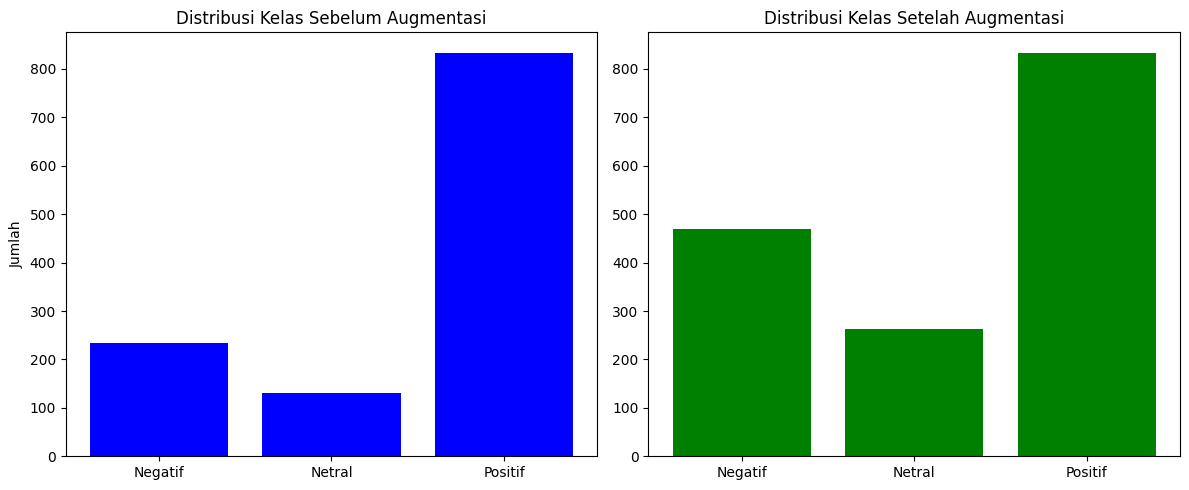


Perbandingan Augmentasi untuk Ketiga Model:
- Metode: Back Translation menggunakan MarianMT (Helsinki-NLP/opus-mt-en-fr dan fr-en)
- Kelas yang diaugmentasi: Negatif (0) dan Netral (1)
- Tujuan: Menyeimbangkan distribusi kelas dengan menambah data sintetis untuk kelas minoritas
- Penerapan:
  - MultiBERT: Augmentasi diterapkan pada teks sebelum tokenisasi BERT
  - LSTM FastText: Augmentasi diterapkan pada teks sebelum tokenisasi dan embedding FastText
  - CNN GloVe: Augmentasi diterapkan pada teks sebelum tokenisasi dan embedding GloVe
- Dampak: Distribusi kelas menjadi lebih seimbang, meningkatkan performa pada kelas minoritas

Tabel Arsitektur Model:
+---------------+--------------------------------------------------------------------------------------------+------------------------------------------------------------+---------------------------------------------------------+
| Model         | Lapisan Utama                                                                             

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Analisis disimpan di /content/drive/MyDrive/colab/augmentation_architecture_analysis.txt


In [3]:
# Compare_Augmentation_Architecture.ipynb
import pandas as pd
import numpy as np
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import MarianMTModel, MarianTokenizer
import torch
from tabulate import tabulate

# Verifikasi versi library
print(f"Versi pandas: {pd.__version__}")
print(f"Versi numpy: {np.__version__}")
print(f"Versi torch: {torch.__version__}")

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

# Load dataset
dataset_path = '/content/drive/MyDrive/colab/amazon_reviews_unbalanced.csv'
print(f"Loading dataset from {dataset_path}...")
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"Dataset tidak ditemukan di {dataset_path}.")
df = pd.read_csv(dataset_path)

# Preprocessing
texts = df['text'].values
labels = df['sentiment'].map({'Positif': 2, 'Netral': 1, 'Negatif': 0}).values

# Split data
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Fungsi untuk back translation
def back_translate(texts, source_lang="en", target_lang="fr", max_retries=3):
    for attempt in range(max_retries):
        try:
            model_name = f'Helsinki-NLP/opus-mt-{source_lang}-{target_lang}'
            tokenizer = MarianTokenizer.from_pretrained(model_name, cache_dir='/content/hf_cache')
            model = MarianMTModel.from_pretrained(model_name, cache_dir='/content/hf_cache').to('cuda' if torch.cuda.is_available() else 'cpu')

            translated = []
            for text in texts:
                inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
                translated_ids = model.generate(**inputs)
                translated_text = tokenizer.decode(translated_ids[0], skip_special_tokens=True)
                translated.append(translated_text)

            model_name_back = f'Helsinki-NLP/opus-mt-{target_lang}-{source_lang}'
            tokenizer_back = MarianTokenizer.from_pretrained(model_name_back, cache_dir='/content/hf_cache')
            model_back = MarianMTModel.from_pretrained(model_name_back, cache_dir='/content/hf_cache').to('cuda' if torch.cuda.is_available() else 'cpu')

            back_translated = []
            for text in translated:
                inputs = tokenizer_back(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda' if torch.cuda.is_available() else 'cpu')
                back_translated_ids = model_back.generate(**inputs)
                back_translated_text = tokenizer_back.decode(back_translated_ids[0], skip_special_tokens=True)
                back_translated.append(back_translated_text)

            return back_translated
        except Exception as e:
            print(f"Percobaan {attempt+1} gagal: {e}")
            if attempt == max_retries - 1:
                print("Gagal melakukan back translation. Menggunakan teks asli.")
                return texts

# Analisis distribusi kelas sebelum augmentasi
train_df = pd.DataFrame({'text': X_train, 'sentiment': y_train})
class_counts_before = train_df['sentiment'].value_counts().sort_index()
print("\nDistribusi kelas sebelum augmentasi:")
print(class_counts_before)

# Data augmentation dengan back translation
print("\nPerforming back translation for data augmentation...")
max_count = class_counts_before.max()
augmented_texts = []
augmented_labels = []
for label in [0, 1]:  # Negatif dan Netral
    class_texts = train_df[train_df['sentiment'] == label]['text'].values
    num_to_generate = max_count - len(class_texts)
    if num_to_generate > 0:
        selected_texts = np.random.choice(class_texts, size=min(num_to_generate, len(class_texts)), replace=True)
        aug_texts = back_translate(selected_texts)
        augmented_texts.extend(aug_texts)
        augmented_labels.extend([label] * len(aug_texts))

X_train_aug = np.concatenate([X_train, augmented_texts])
y_train_aug = np.concatenate([y_train, augmented_labels])

# Analisis distribusi kelas setelah augmentasi
aug_df = pd.DataFrame({'sentiment': y_train_aug})
class_counts_after = aug_df['sentiment'].value_counts().sort_index()
print("\nDistribusi kelas setelah augmentasi:")
print(class_counts_after)

# Visualisasi distribusi kelas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(['Negatif', 'Netral', 'Positif'], class_counts_before, color='blue')
ax1.set_title('Distribusi Kelas Sebelum Augmentasi')
ax1.set_ylabel('Jumlah')
ax2.bar(['Negatif', 'Netral', 'Positif'], class_counts_after, color='green')
ax2.set_title('Distribusi Kelas Setelah Augmentasi')
plt.tight_layout()
plt.show()

# Perbandingan augmentasi
print("\nPerbandingan Augmentasi untuk Ketiga Model:")
print("- Metode: Back Translation menggunakan MarianMT (Helsinki-NLP/opus-mt-en-fr dan fr-en)")
print("- Kelas yang diaugmentasi: Negatif (0) dan Netral (1)")
print("- Tujuan: Menyeimbangkan distribusi kelas dengan menambah data sintetis untuk kelas minoritas")
print("- Penerapan:")
print("  - MultiBERT: Augmentasi diterapkan pada teks sebelum tokenisasi BERT")
print("  - LSTM FastText: Augmentasi diterapkan pada teks sebelum tokenisasi dan embedding FastText")
print("  - CNN GloVe: Augmentasi diterapkan pada teks sebelum tokenisasi dan embedding GloVe")
print("- Dampak: Distribusi kelas menjadi lebih seimbang, meningkatkan performa pada kelas minoritas")

# Tabel arsitektur model
architecture_table = [
    ["Model", "Lapisan Utama", "Embedding", "Parameter Penting"],
    ["MultiBERT",
     "BERT (12 transformer layers, 12 attention heads, 768 hidden units) + Dense(128) + Dense(3)",
     "BERT Tokenizer (bert-base-multilingual-cased, 768 dimensi)",
     "Trainable: BERT weights fine-tuned, Dense layers"],
    ["LSTM FastText",
     "LSTM(128 units, bidirectional) + Dense(64) + Dense(3)",
     "FastText (wiki-news-300d-1M, 300 dimensi, trainable=False)",
     "Trainable: LSTM, Dense layers; Batch size=16, Epochs=5"],
    ["CNN GloVe",
     "Conv1D(128 filters, kernel=5) + GlobalMaxPooling1D + Dense(64) + Dense(3)",
     "GloVe (glove.6B.300d, 300 dimensi, trainable=False)",
     "Trainable: Conv1D, Dense layers; Batch size=8, Epochs=5"]
]

print("\nTabel Arsitektur Model:")
print(tabulate(architecture_table, headers="firstrow", tablefmt="grid"))

# Simpan hasil analisis
output_path = '/content/drive/MyDrive/colab/augmentation_architecture_analysis.txt'
with open(output_path, 'w') as f:
    f.write("Perbandingan Augmentasi untuk Ketiga Model:\n")
    f.write("- Metode: Back Translation menggunakan MarianMT\n")
    f.write("- Kelas yang diaugmentasi: Negatif (0) dan Netral (1)\n")
    f.write("- Tujuan: Menyeimbangkan distribusi kelas\n")
    f.write("- Penerapan:\n")
    f.write("  - MultiBERT: Augmentasi sebelum tokenisasi BERT\n")
    f.write("  - LSTM FastText: Augmentasi sebelum tokenisasi FastText\n")
    f.write("  - CNN GloVe: Augmentasi sebelum tokenisasi GloVe\n")
    f.write("\nDistribusi Kelas Sebelum Augmentasi:\n")
    f.write(str(class_counts_before) + "\n")
    f.write("\nDistribusi Kelas Setelah Augmentasi:\n")
    f.write(str(class_counts_after) + "\n")
    f.write("\nTabel Arsitektur Model:\n")
    f.write(tabulate(architecture_table, headers="firstrow", tablefmt="plain"))
files.download(output_path)

print(f"\nAnalisis disimpan di {output_path}")